# References

https://github.com/jasonwei20/eda_nlp/blob/04ab29c5b18d2d72f9fa5b304322aaf4793acea0/code/eda.py#L86

# Imports

In [63]:
import pandas as pd
pd.options.display.max_columns = 50   # max displayed columns
pd.options.display.max_colwidth = 280 # width of a column

import matplotlib.pyplot as plt
from collections import defaultdict

import random
random.seed(42)
np.random.RandomState(1)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
sw = stopwords.words('english')

from googletrans import Translator

import xgboost
# from imblearn.over_sampling import SMOTE 
NB_n_jobs = -2

In [2]:
## Uncomment below and run if you nltk throws up errors
#nltk.download('omw-1.4')

In [3]:
import sys
sys.path.append( 'src' )
from pandas_functions import *

In [4]:
dataFolder_path = 'data/'

# Helper functions

In [5]:
# To be put in src

def doc_preparer(doc, stem = False, stop_words=sw):
    '''

    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
            
    Courtesy of Flatiron's lecture materials - 
    credit due to Daniel on helping me figure out the regex pattern to exclude Twitter mentions.
    '''

    
    # Instantiate regex tokenizer
    regex_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)" 
    regex_token = RegexpTokenizer(regex_pattern)
    
    # Tokenize using regex pattern
    doc = regex_token.tokenize(doc)
    
    # Lowercase all letters
    doc = [word.lower() for word in doc]
    
    # Remove stop words
    doc = [word for word in doc if word not in sw]
   
    # Stemming
    if stem:
        p_stemmer = nltk.stem.PorterStemmer()
        doc = [p_stemmer.stem(word) for word in doc]
        
    return ' '.join(doc)


def cv_printScores(cv_metric):
    '''
    Generic pretty printer of a cross validation
    '''
    print('CV Results')
    print('='*32)
    print('Accuracy')
    print('-'*32)
    print(f"Training accuracy: {cv_metric['train_accuracy'].mean():.3f}")
    print(f"Test accuracy:     {cv_metric['test_accuracy'].mean():.3f}")
    print('F-1 Score')
    print('-'*32)
    print(f"Training F1 score: {cv_metric['train_f1_macro'].mean():.3f}")
    print(f"Test F1 score:     {cv_metric['test_f1_macro'].mean():.3f}")
    

    
def getTopWordFreq(df,col,n):
    '''
    generates FreqDist and prints out top n words
    df: dataframe
    col: column you want to run a freqDist on
    n: number of most common items    
    '''
    word_freq = FreqDist()
    for text in df[col].map(lambda x:doc_preparer(x,stem=False)):
        for word in text.split():
            word_freq[word] +=1
    return word_freq.most_common(n=n)

# Data: Loading, Cleaning, and Munging

## Describe data here!!!!

This dataset is a subset of webscraped twitter data that was gathered (presumably) at the SXSW festival that is held annually at Austin, Texas. It is self described as a meeting of music, tech and film.


This data was gathered from CrowdFlower. Per CrowdFlower:

Description:
>Judge Emotion About Brands and Products

Summary:
>Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093 Download Now

Source:
https://www.crowdflower.com/data-for-everyone/

## Loading

In [6]:
data_df = pd.read_csv(dataFolder_path+'judge_1377884607_tweet_product_company.csv')

In [7]:
data_df.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion


In [8]:
data_df.shape

(8721, 3)

## Cleaning

Let's rename the columns for ease of use. Note that `product` is a reserved word in Python; for the second column, initially titled `emotion_in_tweet_is_directed_at`, I use `product_name`.

In [9]:
data_df.rename(columns = {'tweet_text': 'text',
                     'emotion_in_tweet_is_directed_at': 'product_name',
                     'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'},
               inplace = True)

In [10]:
data_df.isna().sum()

text               1
product_name    5552
emotion            0
dtype: int64

Lots of nulls in `product_name`, which we'll have to deal with at one point or another, and exactly *one* null value in the `text` column. Let's check that out real quick...

In [11]:
data_df[data_df.text.isna()]

,text,product_name,emotion
6,NaN,NaN,No emotion toward brand or product


This record has no relevant information associated with it. No useful information can be drawn from it. Dropping this record

In [12]:
data_df.dropna(subset=['text'],inplace=True)

In [13]:
data_df.shape

(8720, 3)

## Munging

In [14]:
dataFrame_info(data_df)

Datframe has 8720 rows and 3 columns


Info Table:  Zeroes          Nulls          Uniques          Missing/Unknown  \
Details:      Count Fraction Count Fraction   Count Fraction           Count   
Columns:                                                                       
text              0   0.00 %     0   0.00 %    8693  99.69 %               0   
product_name      0   0.00 %  5551  63.66 %      10   0.11 %               0   
emotion           0   0.00 %     0   0.00 %       4   0.05 %               0   

Info Table:           Mean Median  
Details:     Fraction              
Columns:                           
text           0.00 %  0.0    0.0  
product_name   0.00 %  0.0    0.0  
emotion        0.00 %  0.0    0.0

There is an extremely large number of nulls in product name, which we will have to account for. For the purpose of modeling, the columns we specifically care about are the `text` and `emotion` columns, since we are going to try and predict the emotional quotient of a tweet.

Let's get a look of how the target column (`emotion`) is distributed.

In [15]:
print(f"Emotion value counts:\n{data_df.emotion.value_counts()}")

Emotion value counts:
No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64


There seems to be a significant imbalance in our data. We can confirm this by normalizing and visualizing the data

Emotion value counts (normalized):
No emotion toward brand or product    0.591170
Positive emotion                      0.329014
Negative emotion                      0.062500
I can't tell                          0.017317
Name: emotion, dtype: float64


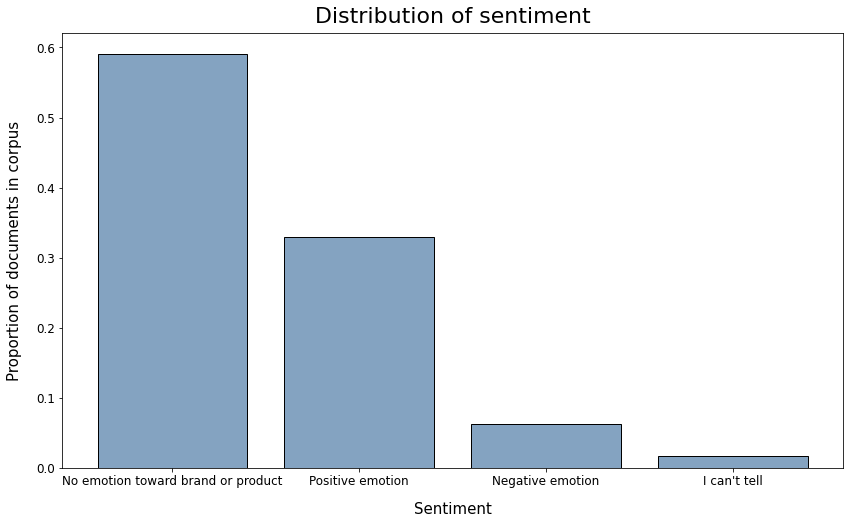

In [16]:
fig, ax = plt.subplots(figsize = (14, 8))

ax.bar(x = data_df.emotion.value_counts(normalize=True).index,
       height = data_df.emotion.value_counts(normalize=True).values,
       color = (0.2, 0.4, 0.6, 0.6),
       edgecolor = 'black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel(xlabel="Sentiment",
              fontsize=15,
              labelpad=14)
ax.set_ylabel(ylabel="Proportion of documents in corpus",
              fontsize=15,
              labelpad=14)
ax.set_title(label="Distribution of sentiment",
             fontsize=22,
             pad=10);



print(f"Emotion value counts (normalized):\n{data_df.emotion.value_counts(normalize=True)}")

`I can't tell` makes up less than 2% of our dataset, and doesn't offer much more information in the way of word significance than the tweets labeled `No emotion toward brand or product`. We will drop records where `emotion` has been recorded as `I can't tell`.

In [17]:
data_df.drop(
    index = data_df[data_df.emotion == "I can't tell"].index,
    inplace = True)

data_df.shape

(8569, 3)

Lets look at some of the most common words

In [18]:
# word_freq = FreqDist()
# for tweet in data_df['tweet_text'].map(lambda x:doc_preparer(x,stem=False)):
#     for word in tweet.split():
#         word_freq[word] +=1
# word_freq.most_common(n=50)

Adding venue specific words and twitter specific words to stopwords

In [19]:
# #Maybe don't add mention? and link?
# sw.extend(['sxsw','rt','quot','austin','sxswi',
#            'mention','link',
#            'today','w'
#           ])

In [20]:
# word_freq = FreqDist()
# for tweet in data_df['tweet_text'].map(lambda x:doc_preparer(x,stem=True)):
#     for word in tweet.split():
#         word_freq[word] +=1
# word_freq.most_common(n=50)

### Improving our stop word list

When working with webscraping and social data mining applications, or NLP problems in general, one of the problems that crops up is there is a large number of words that are commonly used. These words (such as 'a', 'are' etc) will uniquely identify with our `emotion` column since they are so widely used. 
We will be implementing nltk's stopwords module to remove such commonly used english words, however, we can improve upon this list of stopwords.

To do so lets have a quick look at the most frequently used words across all tweets.

In [21]:
# Lower case all text, remove punctuations, ignore stop words, get word frequency
getTopWordFreq(data_df,'text',n=10)

[('sxsw', 9096),
 ('link', 4077),
 ('rt', 2925),
 ('ipad', 2836),
 ('google', 2329),
 ('apple', 2093),
 ('quot', 1582),
 ('iphone', 1492),
 ('store', 1397),
 ('new', 1057)]

<BarContainer object of 10 artists>

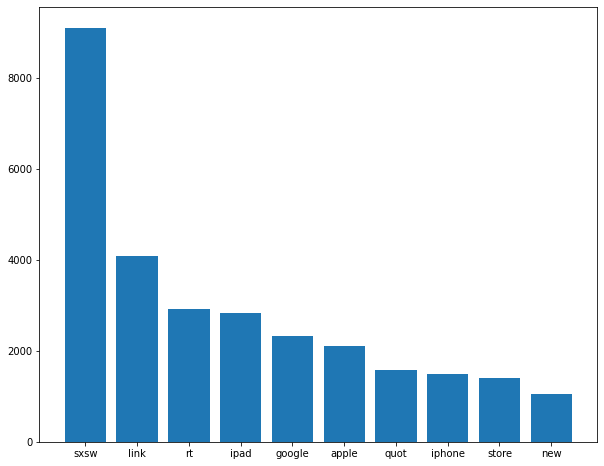

In [22]:
# Plot most frequent words
fig,ax = plt.subplots(figsize = (10,8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df,'text',n=num_of_bars)

ax.bar(x = [word for word,freq in viz_data], 
      height = [freq for word,freq in viz_data])

Just by looking at this, we can see there is a high occurence of 
- venue specific words such  as `sxsw`
- twitter specific words such as `rt`
- brand or product specific words such as `iphone`

These words probably occur across our various sentiments and may not necessarily add any meaning, unless a majority of their occurence is associated with a particular `emotion`

Instead of dropping words that just occur at a high frequency across the entire corpus, we will drop words that occur at a high frequency across our positive and negative emotional quotient.

This should ensure we don't accidentally remove a word from the corpus that is overall heavily represented but is mostly represented in any 1 `emotion`

In [23]:
neg_df = data_df[data_df['emotion']=='Negative emotion']
pos_df = data_df[data_df['emotion']=='Positive emotion']

Sanity Check

In [24]:
neg_df.head(3)

,text,product_name,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion


In [25]:
pos_df.head(3)

,text,product_name,emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [26]:
print('As an example. Here are the top 5 words:')
print(f"Entire DataFrame: {[word for word,freq in getTopWordFreq(data_df,'text',3)]}")
print(f"Positive Emotion: {[word for word,freq in getTopWordFreq(pos_df,'text',3)]}")
print(f"negative Emotion: {[word for word,freq in getTopWordFreq(neg_df,'text',3)]}")

As an example. Here are the top 5 words:
Entire DataFrame: ['sxsw', 'link', 'rt']
Positive Emotion: ['sxsw', 'ipad', 'link']
negative Emotion: ['sxsw', 'ipad', 'quot']


As you can tell, there is going to be a lot of crossover with certain terms (`sxsw`, `ipad` in our example above) which we should remove however, we'd want to retain words that are potentially more identifiable with a certain `emotion`. This is just the top 3 words, and we shall be using a larger set.

In [27]:
num_mostCommon_Words = 50
common_neg_words = [word for word,freq in getTopWordFreq(neg_df, 'text',num_mostCommon_Words)]
common_pos_words = [word for word,freq in getTopWordFreq(pos_df, 'text',num_mostCommon_Words)]
new_sw_words = list(set(common_neg_words).intersection(set(common_pos_words)))
print(len(new_sw_words))
new_sw_words

31


['circles',
 'austin',
 'launch',
 'today',
 'line',
 'google',
 'sxsw',
 'pop',
 'app',
 'quot',
 'social',
 'new',
 'see',
 'link',
 'amp',
 'good',
 'rt',
 'time',
 'store',
 'network',
 'people',
 'get',
 'apps',
 'iphone',
 "i'm",
 'android',
 'ipad',
 'day',
 'apple',
 'like',
 'one']

We shall be appending this to our stopword list. As part of our `doc_preparer()` we shall be removing these words in the future

In [28]:
sw.extend(new_sw_words)

Lets have a look at the word distribution again

<BarContainer object of 10 artists>

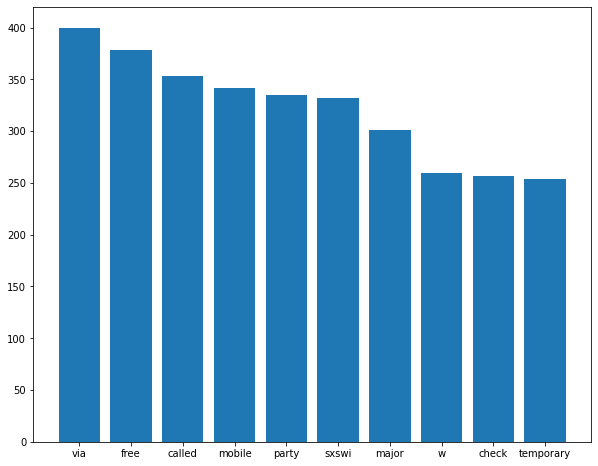

In [29]:
# Plot most frequent words
fig,ax = plt.subplots(figsize = (10,8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df,'text',n=num_of_bars)

ax.bar(x = [word for word,freq in viz_data], 
      height = [freq for word,freq in viz_data])

Already one can tell the skew of the graph is reduced.

### Stemming

We shall be creating a column of a cleaned text string built off of the original tweet

In [30]:
data_df['stemmed_text'] = data_df['text'].map(lambda x:doc_preparer(x,stem=True))

In [33]:
data_df[['text','stemmed_text']].head(5)

,text,stemmed_text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",hr tweet rise dead need upgrad plugin station
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",know awesom like appreci design also they'r give free ts
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,wait also sale
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,hope year' festiv crashi year'
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",great stuff fri marissa mayer tim reilli tech book confer matt mullenweg wordpress


### Label Encoding the sentinment column

To help with our classification models, we shall use a label encoder to encode the target `emotion` into a more computer friendly numerical column

In [36]:
le = LabelEncoder()
data_df['sentiment_target'] = le.fit_transform(data_df.emotion)
le.classes_

array(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'], dtype=object)

In [39]:
data_df[['emotion', 'sentiment_target']].head(10)

,emotion,sentiment_target
0,Negative emotion,0
1,Positive emotion,2
2,Positive emotion,2
3,Negative emotion,0
4,Positive emotion,2
5,No emotion toward brand or product,1
7,Positive emotion,2
8,Positive emotion,2
9,Positive emotion,2
10,Positive emotion,2


# Train-Test-Split

In [43]:
X = data_df['stemmed_text']
y = data_df['sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# Modeling

## CountVec with MNB

In [77]:
#Pipeline
cvec_mnb_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
cvec_mnb_cvResults = cross_validate(cvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(cvec_mnb_cvResults)

CV Results
Accuracy
--------------------------------
Training accuracy: 0.831
Test accuracy:     0.661
F-1 Score
--------------------------------
Training F1 score: 0.770
Test F1 score:     0.512


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    0.0s finished


We can already see some significant overfitting. This might be due to such a small and imbalanced dataset.

## TiffyDiffy with MNB

In [78]:
#Pipeline
tvec_mnb_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
tvec_mnb_cvResults = cross_validate(tvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(tvec_mnb_cvResults)

CV Results
Accuracy
--------------------------------
Training accuracy: 0.762
Test accuracy:     0.658
F-1 Score
--------------------------------
Training F1 score: 0.523
Test F1 score:     0.400


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    0.0s finished


Using a TF-IDF vectorizer improves accuracy but at a major cost to the F1-score

## CountVec with RF

In [79]:
#Pipeline
cvec_rfc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_rfc_cvResults = cross_validate(cvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(cvec_rfc_cvResults)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.968
Test accuracy:     0.676
F-1 Score
--------------------------------
Training F1 score: 0.967
Test F1 score:     0.554


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    3.7s finished


This is model is severely overfitting but it performs marginally better than the `MultinomialNB()` model

## TiffyDiffy with RandomForest

In [80]:
#Pipeline
tvec_rfc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_rfc_cvResults = cross_validate(tvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(tvec_rfc_cvResults)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.968
Test accuracy:     0.677
F-1 Score
--------------------------------
Training F1 score: 0.967
Test F1 score:     0.543


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    3.7s finished


In [ ]:
# params = {}
# params['rfc__criterion'] = ['gini','entropy']
# params['rfc__n_estimators'] = np.arange(50,250,50)
# params['rfc__max_depth'] = np.arange(150,200,10)
# # params['rfc__max_leaf_nodes']=[4000,4500,5000]

# rfc_model_pipe = Pipeline([
#     ('vec',TfidfVectorizer()),
#    ('rfc',RandomForestClassifier(random_state=42,n_jobs=NB_n_jobs))
# ])

# rfc_gs1 = GridSearchCV(estimator=rfc_model_pipe,
#                            param_grid=params,
#                            n_jobs=NB_n_jobs,
#                            scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
#                            refit='accuracy',
#                            return_train_score=True)

# rfc_gs1.fit(X_train,y_train)
# prettyPrintGridCVResults(rfc_gs1)

In [ ]:
# rfc_gs1.best_estimator_.score(X_test,y_test)

## CountVec with GradientBoosting Classifier

In [81]:
#Pipeline
cvec_gbc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_gbc_cvResults = cross_validate(cvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(cvec_gbc_cvResults)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.713
Test accuracy:     0.667
F-1 Score
--------------------------------
Training F1 score: 0.532
Test F1 score:     0.444


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    1.2s finished


## TiffyDiffy with GradientBoosting Classifier

In [84]:
#Pipeline
tvec_gbc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_gbc_cvResults = cross_validate(tvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
cv_printScores(tvec_gbc_cvResults)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.722
Test accuracy:     0.664
F-1 Score
--------------------------------
Training F1 score: 0.563
Test F1 score:     0.449


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.1s finished
